In [ ]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#load dataset
def load_dataset(filename):
    df = pd.read_csv(filename)
    df.rename(columns={'Date/Time':'Time', 'LV ActivePower (kW)':'ActivePower', 'Theoretical_Power_Curve (KWh)':'TheoriticalPower', 'Wind Direction (°)':'WindDirection', 'Wind Speed (m/s)':'Speed'}, inplace=True)
    return df

df = load_dataset("Scada_dataset.csv")

In [ ]:
#function for finding months
def find_month(x):
    if " 01 " in x:
        return 1
    elif " 02 " in x:
        return 2
    elif " 03 " in x:
        return 3    
    elif " 04 " in x:
        return 4    
    elif " 05 " in x:
        return 5    
    elif " 06 " in x:
        return 6    
    elif " 07 " in x:
        return 7    
    elif " 08 " in x:
        return 8    
    elif " 09 " in x:
        return 9    
    elif " 10 " in x:
        return 10    
    elif " 11 " in x:
        return 11    
    else:
        return 12

In [ ]:
#appending date, month and time columns
def append_time(df):
    df['Month'] = df.Time.apply(find_month)
    df['Time']=pd.to_datetime(df.Time)
    df['Day'] = df['Time'].dt.day
    df['Hour'] = df['Time'].dt.hour
    df['Minute'] = df['Time'].dt.minute
    return df
    
df = append_time(df)

In [ ]:
#to categorize direction of wind
def find_direction(x):
    if x==0:
        return "N"
    if x==30:
        return "NNE"
    if x==60:
        return "NEE" 
    if x==90:
        return "E" 
    if x==120:
        return "SEE" 
    if x==150:
        return "SSE" 
    if x==180:
        return "S" 
    if x==210:
        return "SSW" 
    if x==240:
        return "SWW" 
    if x==270:
        return "W" 
    if x==300:
        return "NWW" 
    if x==330:
        return "NNW"

In [ ]:
#to find mean direction from given values
def mean_direction(x):
    list = []
    i = 15
    while i <= 375:
        list.append(i)
        i += 30
        
    for i in list:
        if x < i:
            x = i-15
            if x == 360:
                return 0
            else:
                return x

In [ ]:
#adding features
def add_features(df):
    df["meanDirection"] = df["WindDirection"].apply(mean_direction)
    df["Direction"] = df["meanDirection"].apply(find_direction)
    return df

df = add_features(df)

In [ ]:
#separating features and targets
def features_targets(df):
    X = df.drop(labels = ['Time','TheoriticalPower', 'ActivePower'], axis = 1)
    y = df['ActivePower']
    return X, y
    
X, y = features_targets(df)

In [ ]:
#train test split for regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 47)

In [ ]:
X_train_enc = pd.concat([X_train['WindDirection'], pd.get_dummies(X_train, prefix = 'Dir')], axis = 1) 
X_train_enc.drop('WindDirection', axis = 1, inplace = True)
X_test_enc = pd.concat([X_test['WindDirection'], pd.get_dummies(X_test, prefix = 'Dir')], axis = 1)
X_test_enc.drop('WindDirection', axis = 1, inplace = True)

In [ ]:
#predict new data
def model_predict(model, X_test):
   y_pred = model.predict(X_test)
   return y_pred
   

In [ ]:
#error calculation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
def reg_model_accuracy(model, x_test, y_pred, y_test):
    acc = model.score(x_test, y_test)
    MSE = np.sqrt(mean_squared_error(y_test, y_pred))
    #MAE = mean_absolute_error(y_test, y_pred)
    return acc, MSE


In [ ]:
#Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
def models(x_train, y_train, x_test, y_test):

    #Lineear Regression
    model1 = LinearRegression().fit(x_train, y_train.values.reshape(len(y_train), 1))
    y_pred = model_predict(model1, x_test)
    acc, mse = reg_model_accuracy(model1, x_test, y_pred, y_test)
    print("Linear Regressor accuracy: " + str(acc*100) + "%")
    print("Linear Regressor MSE: " + str(mse))
    #Bayesian Ridge
    model2 = BayesianRidge().fit(x_train, y_train.values.reshape(len(y_train), 1))
    y_pred = model_predict(model2, x_test)
    acc, mse = reg_model_accuracy(model2, x_test, y_pred, y_test)
    print("Bayesian Ridge Regressor accuracy: " + str(acc*100) + "%")
    print("Bayesian Ridge Regressor MSE: " + str(mse))
    #RandomForest Regression
    model3 = RandomForestRegressor().fit(x_train, y_train.values.ravel())
    y_pred = model_predict(model3, x_test)
    acc, mse = reg_model_accuracy(model3, x_test, y_pred, y_test)
    print("RandomForest Regressor accuracy: " + str(acc*100) + "%")
    print("RandomForest Regressor MSE: " + str(mse))

models(X_train_enc, y_train, X_test_enc, y_test)

Linear Regressor accuracy: 84.25320755666658%
Linear Regressor MSE: 521.6405584405286
Bayesian Ridge Regressor accuracy: 84.25361369105089%
Bayesian Ridge Regressor MSE: 521.6338314345735


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomForest Regressor accuracy: 97.4818073560042%
RandomForest Regressor MSE: 208.60262783878704


In [ ]:
#LSTM preprocessing
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
#ordinal encoding features: direction
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
def feature_encoding(X):
    #encoding cols
    X = pd.concat([X['Direction'], pd.get_dummies(X, prefix = 'dir')], axis = 1) 
    X.drop('Direction', axis = 1, inplace = True)
    return X

X = feature_encoding(X)

In [ ]:
#LSTM Scaling
from sklearn.preprocessing import MinMaxScaler
def scale(X):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(X)
    reframed = series_to_supervised(scaled,1,1)
    reframed.drop(reframed.columns[[21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]], axis=1, inplace=True)
    return reframed

reframed = scale(X)
values = reframed.values;

In [ ]:
#LSTM train test split
import math
def data_split(df):
  x,y = df.shape
  n_train = int(math.ceil(x*0.8))
  train = df[:n_train]
  test = df[n_train:]
  trainX,trainY = train[:,:-1],train[:,-1]
  testX,testY = test[:,:-1],test[:,-1]
  trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
  testX = testX.reshape(testX.shape[0],1,testX.shape[1])
  return trainX, testX, trainY, testY

X_train, X_test, y_train, y_test = data_split(values);

In [ ]:
#Model 4: LSTM neural networks training
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense,LSTM,GRU
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

def LSTM_train(X_train, X_test):
    stop_noimprovement = EarlyStopping(patience=10)
    model4 = Sequential()
    model4.add(LSTM(50,input_shape=(X_train.shape[1], X_train.shape[2]),dropout=0.2))
    model4.add(Dense(1))
    model4.compile(optimizer = 'adam', loss = 'mae',metrics=['mae','mse','mape','cosine'])
    #Check Point
    checkpoint_name = 'req_model.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='loss', verbose = 1, save_best_only = True, mode ='max');
    callbacks_list = [checkpoint]
    history = model4.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,verbose=1,shuffle=False);
    return model4, history

model4, history = LSTM_train(X_train, X_test);

Using TensorFlow backend.


Train on 40424 samples, validate on 10105 samples
Epoch 1/100
40424/40424 [==============================] - 4s 87us/step - loss: 0.0901 - mae: 0.0901 - mse: 0.0255 - mape: 416222.6250 - cosine: 0.9958 - val_loss: 0.0740 - val_mae: 0.0740 - val_mse: 0.0179 - val_mape: 260930.2812 - val_cosine: 0.9988
Epoch 2/100
40424/40424 [==============================] - 3s 72us/step - loss: 0.0725 - mae: 0.0725 - mse: 0.0193 - mape: 444441.2812 - cosine: 0.9970 - val_loss: 0.0614 - val_mae: 0.0614 - val_mse: 0.0144 - val_mape: 279425.7500 - val_cosine: 0.9988
Epoch 3/100
40424/40424 [==============================] - 3s 71us/step - loss: 0.0629 - mae: 0.0629 - mse: 0.0167 - mape: 467736.2812 - cosine: 0.9964 - val_loss: 0.0521 - val_mae: 0.0521 - val_mse: 0.0118 - val_mape: 281526.6562 - val_cosine: 0.9988
Epoch 4/100
40424/40424 [==============================] - 3s 70us/step - loss: 0.0549 - mae: 0.0549 - mse: 0.0162 - mape: 461842.5938 - cosine: 0.9934 - val_loss: 0.0489 - val_mae: 0.0489 - val

In [ ]:
#error calculation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
def lstm_model_accuracy(y_pred, y_test):
    MSE = np.sqrt(mean_squared_error(y_test, y_pred))
    acc = 0
    #MAE = mean_absolute_error(y_test, y_pred)
    return acc, MSE

In [ ]:
#LSTM prediction
y_pred = model_predict(model4, X_test)
#LSTM accuracy

#error calculation
acc, mse = lstm_model_accuracy(y_pred, y_test)
#print("LSTM Regressor accuracy: " + str(acc*100) + "%")
print("LSTM Regressor MSE: " + str(mse))

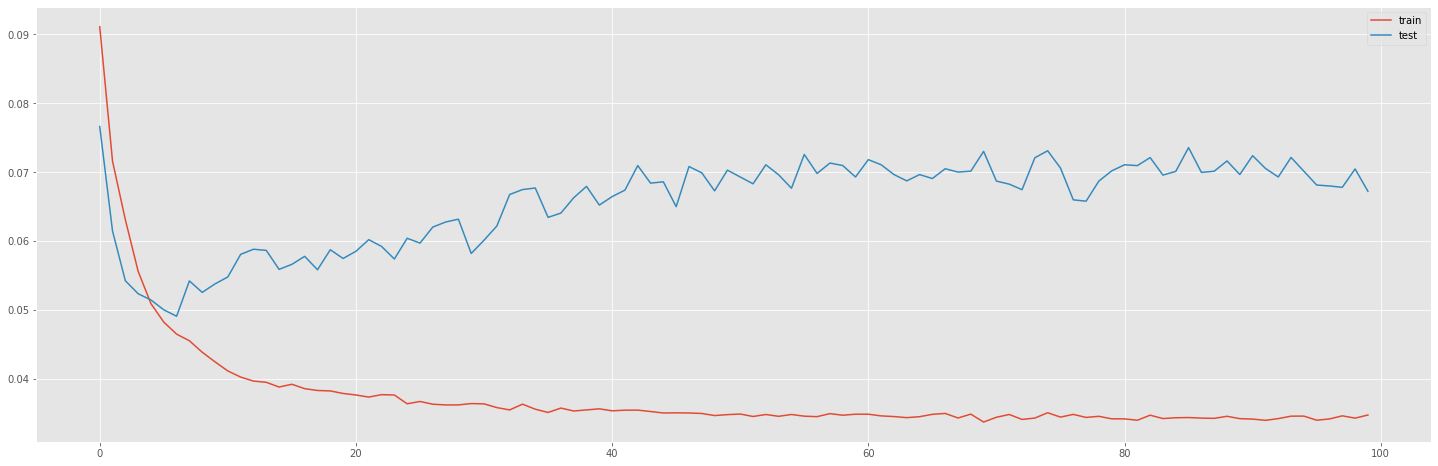

In [ ]:
#LSTM performance
from pylab import rcParams
def plot_history(history):

    #plotting style
    plt.style.use("ggplot");
    #plotting data
    plt.figure(figsize=(25, 8));
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='test')
    plt.legend()
    plt.show()
    
plot_history(history)